In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import matplotlib.pyplot as plt
import runpy

result = runpy.run_path('datasorting_orientation.py')

datasorting_orientation.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_cat.append(np.array(data_catt))
datasorting_orientation.py:72: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_cat.append(np.array(val_catt))
datasorting_orientation.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dur_cat.append(np.array(dur_cat

In [2]:
val_cat = result['val_cat']
data_cat = result['data_cat']
del result

In [3]:
# preprocessing
data_total = []
for a in range(8): # orientation
    temp = np.array(data_cat).T[a]
    t_temp = []
    for data_num in range(np.shape(data_cat)[0]):
        temp2 = np.mean(temp[0],axis=0)
        t_temp.append(temp2)
        
    data_total.append(t_temp)

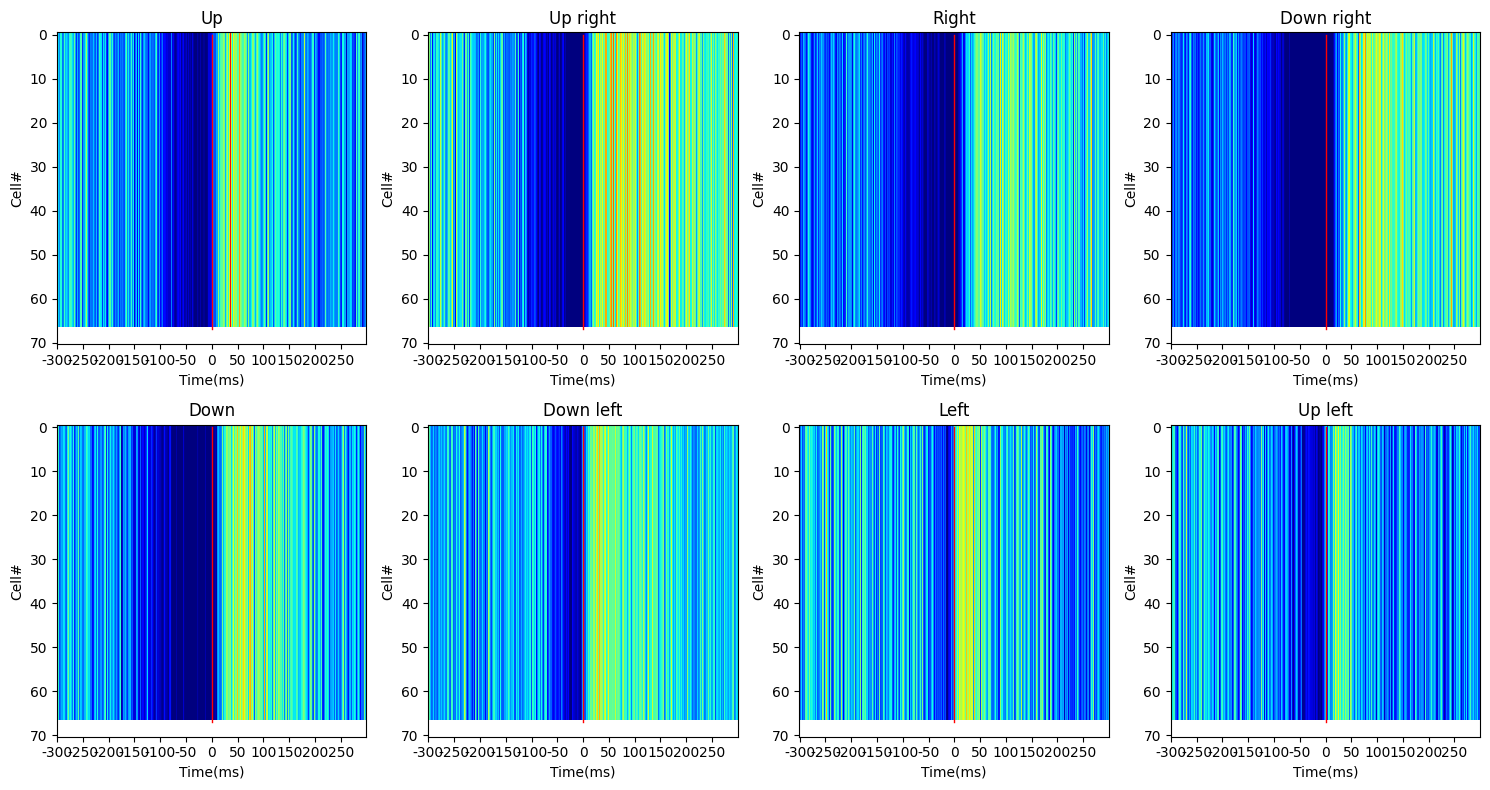

In [4]:
# Plotting raw data of each orientation
label_ori = ['Up', 'Up right', 'Right', 'Down right',
             'Down', 'Down left', 'Left', 'Up left']

fig, axes = plt.subplots(2, 4, figsize=(15, 8))

for a in range(8):
    ax = axes[a // 4, a % 4]  # Determine the subplot location
    ax.imshow(data_total[a], aspect='auto', cmap='jet', origin='upper')  # Display the data
    ax.plot([300, 300], [0, len(data_total[0])], 'r', linewidth=1)  # Red vertical line
    ax.set_xticks(np.arange(0, 600, 50))  # Set X ticks
    ax.set_xticklabels(np.arange(-300, 300, 50))  # Set X tick labels
    ax.set_title(label_ori[a])  # Set the title for each subplot
    ax.set_ylabel("Cell#")  # Set Y-axis label
    ax.set_xlabel("Time(ms)")  # Set X-axis label

plt.tight_layout()
plt.show()

In [5]:
# smothing

from filter_matrix import filter_matrix

data_cat_sm = []
for angle in range(8):
    temp_cat = [];
    for n in range(np.shape(data_cat)[0]):
        z = data_cat[n][angle]
        zf = filter_matrix(z,2)
        temp_cat.append(np.mean(zf,axis=0))
        
    data_cat_sm.append(temp_cat)

data_cat_sm = np.array(data_cat_sm)

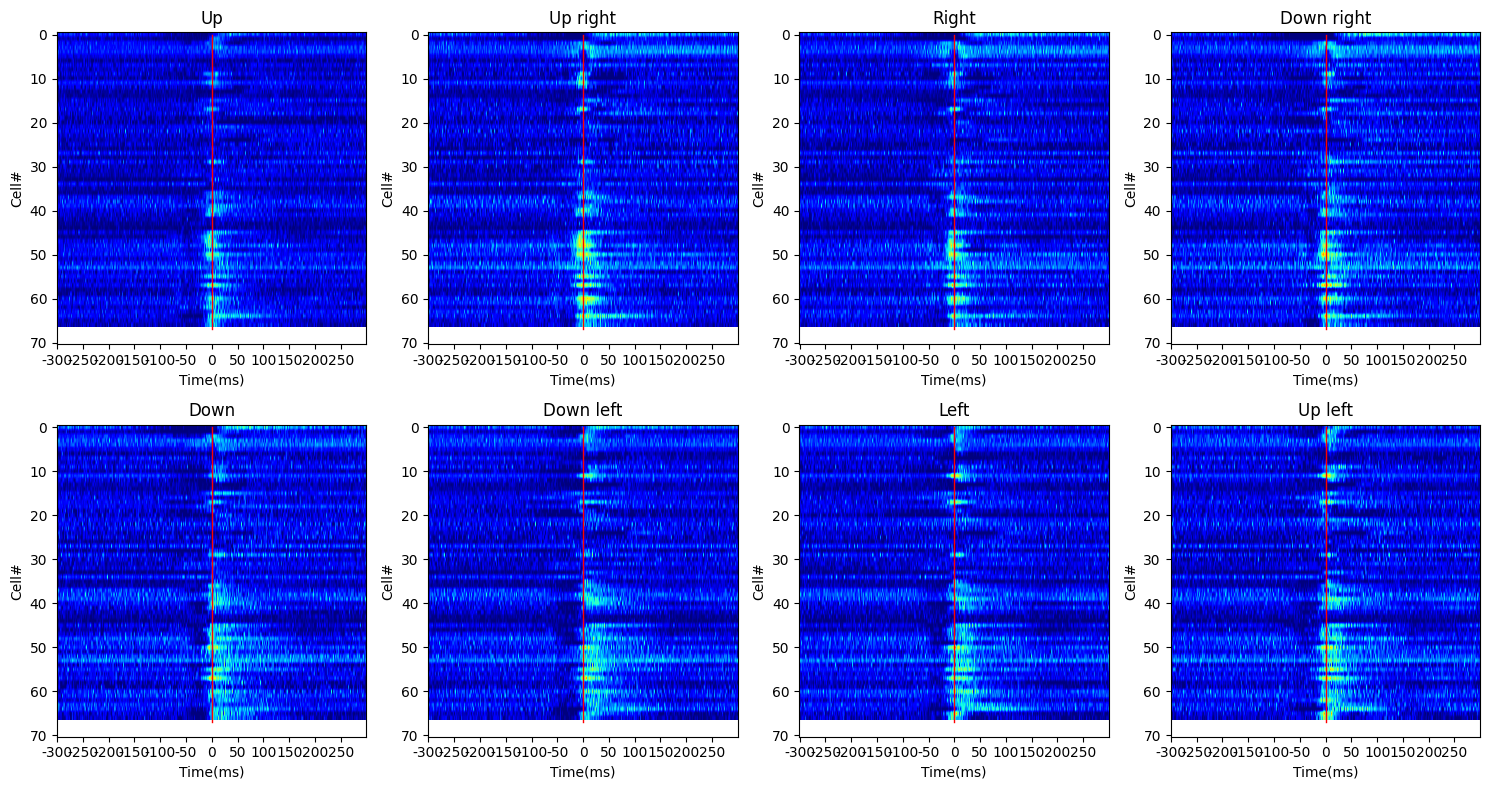

In [6]:
# Plotting raw data of each orientation
label_ori = ['Up', 'Up right', 'Right', 'Down right',
             'Down', 'Down left', 'Left', 'Up left']

fig, axes = plt.subplots(2, 4, figsize=(15, 8))

for a in range(8):
    ax = axes[a // 4, a % 4]  # Determine the subplot location
    ax.imshow(data_cat_sm[a], aspect='auto', cmap='jet', origin='upper')  # Display the data
    ax.plot([300, 300], [0, len(data_cat_sm[0])], 'r', linewidth=1)  # Red vertical line
    ax.set_xticks(np.arange(0, 600, 50))  # Set X ticks
    ax.set_xticklabels(np.arange(-300, 300, 50))  # Set X tick labels
    ax.set_title(label_ori[a])  # Set the title for each subplot
    ax.set_ylabel("Cell#")  # Set Y-axis label
    ax.set_xlabel("Time(ms)")  # Set X-axis label

plt.tight_layout()
plt.show()

In [11]:
data_cat_sm.shape

(8, 67, 600)

Dimensions: 1, Variance explained: 18.91%
Dimensions: 2, Variance explained: 22.96%
Dimensions: 3, Variance explained: 26.21%
Dimensions: 4, Variance explained: 29.30%
Dimensions: 5, Variance explained: 31.95%
Dimensions to be reduced: 43


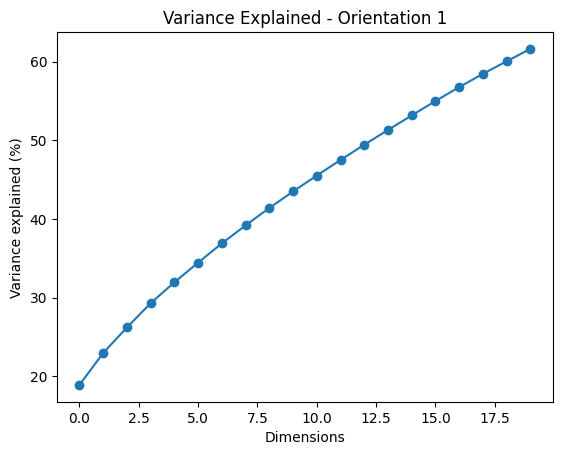

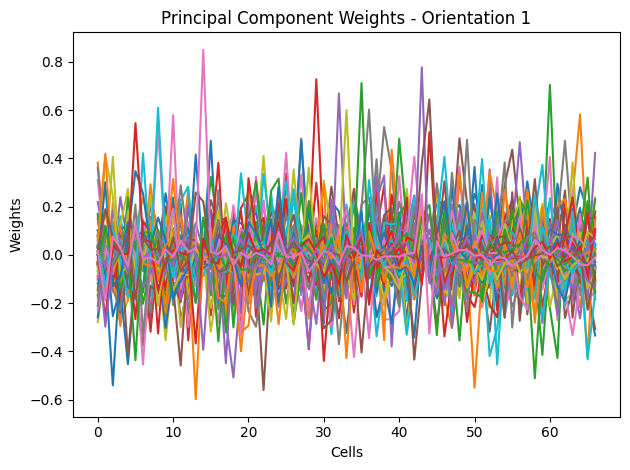

ValueError: x and y must have same first dimension, but have shapes (600,) and (67,)

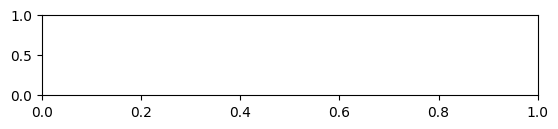

In [7]:
# PCA analysis

from sklearn.decomposition import PCA

PCA_total = {}

# Loop over the orientations (assuming 8 orientations)
for ori in range(8):
    temp_data = data_cat_sm[ori].T  # Transpose to match the MATLAB orientation
    pca = PCA()
    pca.fit(temp_data)  # Perform PCA

    # Get the explained variance ratio and cumulative sum
    var_explained = np.cumsum(pca.explained_variance_ratio_) * 100
    
    # Print the variance explained for the first 5 components
    for i in range(5):
        print(f'Dimensions: {i+1}, Variance explained: {var_explained[i]:.2f}%')

    # Find the dimension to reduce to based on cumulative variance explained
    nmode = np.argmax(var_explained > 87.5) + 1  # Adding 1 since indexing is 1-based in MATLAB
    print(f'Dimensions to be reduced: {nmode}')
    
    # Plot variance explained
    plt.figure()
    plt.plot(var_explained[:20], 'o-', label="Cumulative variance explained")
    plt.xlabel('Dimensions')
    plt.ylabel('Variance explained (%)')
    plt.title(f'Variance Explained - Orientation {ori + 1}')
    plt.show()
    
    # Plot the principal component weights (the eigenvectors)
    plt.figure()
    plt.plot(pca.components_.T)  # The components are in rows, so transpose for plotting
    plt.xlabel('Cells')
    plt.ylabel('Weights')
    plt.title(f'Principal Component Weights - Orientation {ori + 1}')
    plt.tight_layout()
    plt.show()

    # Plot the principal component time series (scores)
    plt.figure()
    hx = []
    for i in range(min(nmode, 4)):  # Plot the first 4 components or up to nmode
        ax = plt.subplot(4, 1, i + 1)
        hx.append(ax)
        ax.plot(np.arange(-300, 300), pca.components_[i, :600])  # Assuming 600 time steps
        ax.set_title(f'PC {i + 1}')
        ax.axis('tight')
        ax.get_xaxis().set_ticks([])
    plt.xlabel('Time after saccade onset (ms)')
    plt.tight_layout()
    plt.show()

    # Store PCA results for each orientation
    PCA_total[ori] = {'v': pca.components_, 'p': pca.transform(temp_data), 'dd': pca.explained_variance_}


In [ ]:
# PCA analysis

from sklearn.decomposition import PCA

PCA_total = {};

figure;
num=1;
for ori=1:8; %orientation
    
    temp_data=data_cat_sm{ori};
    [v,p,~,~,dd,~]=pca(temp_data');
    var_explained = cumsum(dd)/sum(dd)*1e2;
    
    for i=1:5
        fprintf('Dimensions: %d, Variance explained: %g', i, var_explained(i));
        fprintf('\n')
    end
    
    nmode = find(var_explained>87.5, 1);
    fprintf('Dimensions to be reduced: %d\n', nmode);
    
    figure;
    plot(100*cumsum(dd(1:20))/sum(dd), 'o-');
    xlabel('Dimensions')
    ylabel('Variance explained (%)')
    
    figure;
    plot(v');
    xlabel('cells')
    ylabel('weights')
    axis tight
    
    figure;
    %     for i=1:nmode
    for i=1:4;
        hx(i) = subplot(4,1,i);
        plot(-300:300-1, p(:,i))
        axis tight
        box off
    end
    linkaxes(hx, 'x')
    xlabel('time after saccade onset (ms)')
    
    PCA_total{ori,1}=v;
    PCA_total{ori,2}=p;
    PCA_total{ori,3}=dd;
    
    num=num+1;
    
end; clear ori

In [ ]:
%% Plotting

close all

win=1; %timewindow (ms), if sampling rate is 1000hz, win=10 is 10ms

color=[];
for a=0:7;
    t_color=[1 0+1/9*a 0+1/9*a];
    color=[color;t_color];
end; clear a

figure
for ori=1:8;
    
    temp_PC=PCA_total{ori,2};
    
    s_temp1=smoothdata(temp_PC(:,1),'gaussian',win);
    s_temp2=smoothdata(temp_PC(:,2),'gaussian',win);
    s_temp3=smoothdata(temp_PC(:,3),'gaussian',win);
    
    X=s_temp1(1:600); Y=s_temp2(1:600); Z=s_temp3(1:600);
    scatter3(X,Y,Z,10, color(ori,:), "o");
    hold on
end

axis square

xlabel('PC1')
ylabel('PC2')
zlabel('PC3')

%% Plotting each

close all

win=20; %timewindow (ms), if sampling rate is 1000hz, win=10 is 10ms

color=[];
for a=0:7;
    t_color=[1 0+1/9*a 0+1/9*a];
    color=[color;t_color];
end; clear a

figure

for ori=1:8;
    
    temp_PC=PCA_total{ori,2};
    
    s_temp1=smoothdata(temp_PC(:,1),'gaussian',win);
    s_temp2=smoothdata(temp_PC(:,2),'gaussian',win);
    s_temp3=smoothdata(temp_PC(:,3),'gaussian',win);
    
    subplot(1,8,ori)
    X=s_temp1(1:600); Y=s_temp2(1:600); Z=s_temp3(1:600);
    scatter3(X,Y,Z,10, color(ori,:), "o");
    
    axis square
    
    xlabel('PC1')
    ylabel('PC2')
    zlabel('PC3')
    
end; clear ori

figure
num=1:4:32;
for ori=1:8;
    
    temp_PC=PCA_total{ori,2};
    
    s_temp1=smoothdata(temp_PC(:,1),'gaussian',win);
    s_temp2=smoothdata(temp_PC(:,2),'gaussian',win);
    s_temp3=smoothdata(temp_PC(:,3),'gaussian',win);
    s_temp4=smoothdata(temp_PC(:,4),'gaussian',win);
    
    X=s_temp1(1:600); Y=s_temp2(1:600); Z=s_temp3(1:600); Z2=s_temp4(1:600);
    
    subplot(8,4,num(ori))
    plot(-300:300-1,X)    
    xlabel('Time(ms)')
    ylabel('PC1')
    
    subplot(8,4,num(ori)+1)
    plot(-300:300-1,Y)
    xlabel('Time(ms)')
    ylabel('PC2')

    subplot(8,4,num(ori)+2)
    plot(-300:300-1,Z)
    xlabel('Time(ms)')
    ylabel('PC3')
    set(gca, 'YDir','reverse')

    subplot(8,4,num(ori)+3)
    plot(-300:300-1,Z2)
    xlabel('Time(ms)')
    ylabel('PC4')
    
    %     axis square
    
end; clear ori



%% explained

final=[];

for a=1:8;
    
    temp=PCA_total{a,3};
    final=[final temp];
end


%% dummy

%
% f_c=[];
% for t=1:size(temp_data,2);
%
% [coeff,score,latent,tsquared,explained,mu]=pca(temp_data(:,t));
% f_c=[f_c, coeff];
% end
%
% Xcentered = score*coeff'
% biplot(coeff(:,1:2),'scores',score(:,1:2))
%
% X=coeff(:,1); Y=coeff(:,2); Z=coeff(:,3);
% X=score(1,:); Y=score(2,:); Z=score(3,:);
% scatter(X,Y)
%
%
% %%
%
% data_num=1;
%
% temp_data=data_total{data_num};
%
% for a=1:size(temp_data,2);
%
%     [coeff,score,latent,tsquared,explained,mu]=pca(temp_data(:,:)');